# Simulace šíření nákazy - zjednodušený 2D model

Následujícím kódem naimportujeme balíčky. Budeme používat knihovnu **numpy** s aliasem **np** pro matematické funkce a práci s poli a knihovnu **matplotlib** s aliasem **plt** pro vykreslování výsledků. Pro pěknou vizualizaci průběhu simulace si také vyzkoušíme animace **FuncAnimation** z knihovny matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Pro interaktivní vykreslování grafů v Jupyter notebooku ještě potřebujeme toto:

In [2]:
%matplotlib notebook

Budeme simulovat časový vývoj šíření nemoci v populaci. Nejprve si nastavíme několik parametrů: **pocet_lidi**, **delka_simulace** v minutách a **cas_krok** v minutách. **pocet_lidi** a **delka_simulace** můžeme později pro účely testování libobolně měnit, **cas_krok** však budeme uvažovat jako konstatní což výrazně zjednoduší naši práci.

In [3]:
pocet_lidi=1000 #nezadavejte hodnoty vetsi nez 5000, simulace pak bude velmi pomala
delka_simulace=30*24*60 #30 dni * 24 hodin * 60 minut
cas_krok=15

Princip naší simulace bude následující:
- Jednotliví lidé budou reprezentováni body ve 2D
- Tyto body se budou v čase (jednotlivých časových krocích) pohybovat
- Pokud je někdo nakažen může nakazit lidi ve své blízkosti

### SIR model
SIR model popisuje základní principy šíření nemoci. Je založen na rozdělení populace do ří skupin:
1. **S** (susceptible) - lidé kteří doposud nepřišli do styku s nemocí a mohou se nakazit
2. **I** (infected) - nakažení jedinci, mohou nakazit lidi ze skupiny **S**
3. **R** (removed) - jedinci kteří se už nemohou nakazit (ať už v dobrém - imunita, či zlém - smrt). Budeme uvažovat, že po pevně dané době se z **I** stává **R**


## Úkol 1: vygenerujte pro každého néhodnou pozici z [0,1]x[0,1] a vykreslete

<IPython.core.display.Javascript object>


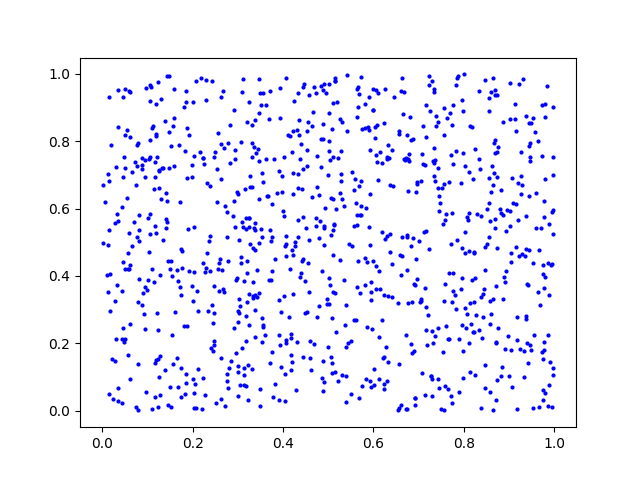

In [4]:
pozice = np.random.rand(pocet_lidi,2)
plt.figure()
plt.plot(pozice[:,0],pozice[:,1],"bo",markersize=2)

Dále vyrobíme numpy pole, která budou identifikovat jednotlivé skupiny **S, I, R**. Budou to pole pouze 0 a 1, to nám umožní je využívat pro indexaci.

In [5]:
S = np.full(pocet_lidi,True)
I = np.full(pocet_lidi,False)
R = np.full(pocet_lidi,False)

## Úkol 2: převeďte lidi 0-99 z S do I a lidi 100-199 z S do R, vykreslete (S-modrá, I-červená, R-zelená)

<IPython.core.display.Javascript object>


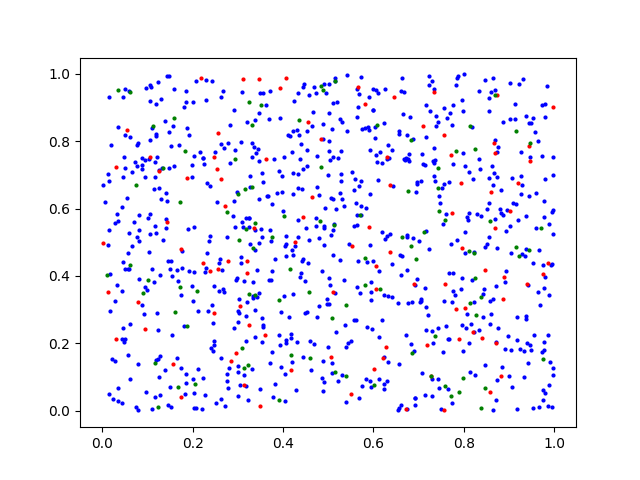

In [6]:
I[0:99]=True
R[100:199]=True
S[0:199]=False

plt.figure()
plt.plot(pozice[S,0],pozice[S,1],"bo",markersize=2)
plt.plot(pozice[I,0],pozice[I,1],"ro",markersize=2)
plt.plot(pozice[R,0],pozice[R,1],"go",markersize=2)

Abychom se mohli dostat dále, ukážeme si jak se dělají animace. Budeme používat funkci **FuncAnimation**, která pracuje následovně:
- má 4 základní parametry:
 - objekt figure z matplotlib (**fig**)
 - námi vytvořená funkce říkejme jí **update**
 - iterovatelé pole (**frmes**), případně počet framů (pokud je vstupem iterovatelné pole, pak je počet framů velikost tohoto pole)
 - touple dodaečných parametrů **fargs**
- pro nás nejdůležitější bude funkce **update**, projděme si tedy její vlastnosti:
 - jako vstup bude dostávat jednotlivé položky vstupu **frames**
 - zavolá se jednou pro každou položku **frames**, bede tedy obsahovat celou naši simulaci jednoho časového kroku
 - bude obsahovat aktualizace součástí grafů které budeme chtít mezi jednotlivými framy měnit
 - na výstupu musí být sekvence součástí grafů, které chceme aktualizovat

Aby jste si udělali lepší představu, ukážeme demostraci:

Nejprve vyrobení grafu do kterého budeme vykreslovat animaci. Pro jednoduché znovupoužití bez kopírování si na to napíšeme funkci:

In [7]:
def nova_animace():
    figure_animace, axs = plt.subplots(ncols=1) #jednoduchý způsob jak najednou vyrobit figure včetně os
    ln1, = axs.plot(pozice[S,0],pozice[S,1],"bo",markersize=2) #graf do konkrétních os (axs)
    ln2, = axs.plot(pozice[I,0],pozice[I,1],"ro",markersize=2)
    ln3, = axs.plot(pozice[R,0],pozice[R,1],"go",markersize=2)

    #text v pravo dolů relativně vůči osám, typ textu monospaced
    title = axs.text(1,0, "text",transform=axs.transAxes, ha="right", va="bottom", fontfamily='monospace') 

    axs.set_xlim(-0.5, 1.5) # rozmesí osy X
    axs.set_ylim(-0.5, 1.5) # rozmesí osy Y
    return figure_animace, ln1, ln2, ln3, title

A jejím zavoláním pak dostaneme graf, nezapomeňte, že všechny komponenty grafu muzí být na výstupu, jinak se nedostanou do kontextu mimo funkci a my je pak nebudeme moci dále použít:

<IPython.core.display.Javascript object>


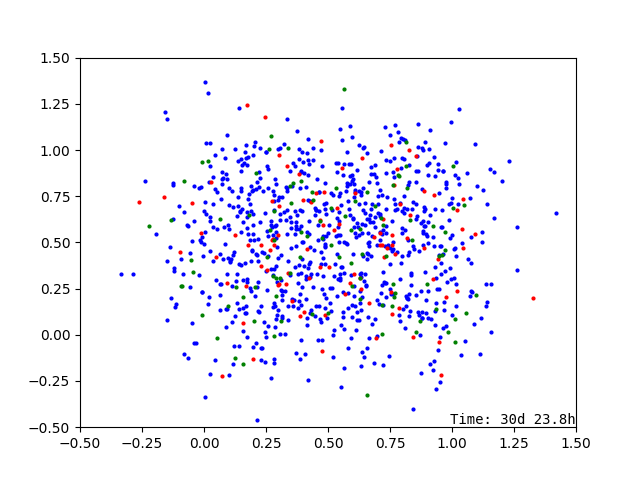

In [8]:
figure_animace, ln1, ln2, ln3, title = nova_animace()

Dále vyrobíme zmíněnou funkci **update**, pro jednodušší použití v dalších úkolech si vyrobíme zvlášť funkci která bude obstarávat vykreslování (jak barevných teček, tak času simulace):

In [9]:
def vykresleni(cas_simulace_minuty):
    ln1.set_xdata(pozice[S,0]) #všechno co se změní se musí aktualizovat 
    ln1.set_ydata(pozice[S,1])
    ln2.set_xdata(pozice[I,0])
    ln2.set_ydata(pozice[I,1])
    ln3.set_xdata(pozice[R,0])
    ln3.set_ydata(pozice[R,1])
    
    cas_simulace_hodiny = np.mod(cas_simulace_minuty/60,24) #napočítáme aktuální čas
    cas_simulace_dny = cas_simulace_minuty/24/60

    title.set_text("Time: {:2.0f}d {:4.1f}h".format(cas_simulace_dny,cas_simulace_hodiny)) #zapíšme aktuální čas
    return

def update(cas_simulace_minuty): #na vstupu budeme uvažovat aktuální čas
    # upravíme pozice, ať vidíme že se něco děje 
    #(pozor na: pozice =... v tu chvíli bychom definovali novou lokální proměnnou, += pouze upraví obsah pozic)
    pozice[:,:] += (np.random.rand(pocet_lidi,2)-0.5)/100 #přičteme k nim náhodné číslo mezi -0.005 s 0.005
    
    vykresleni(cas_simulace_minuty) # zavolání vykreslovací funkce (až potom co upravíme pozice,S,I,R,...)
    return ln1,ln2,ln3,title # musíme vrátit všechny komponenty grafu, které chceme překreslit

Zbývá už jen spustit animaci funkcí **FuncAnimation**, první parmetr je figure ve kterém se bude vše dít, pak updatovací funkce zajišťující samotnou anmaci, dále proměnná frames obsahující sekvenci všech časů ve kterých bude funkce update spuštěna. Dodatečných parametrů si nemusíte všímat, pokud by vás však zajímalo co dělají pak: blit - jestli chceme překreslit vše, nebo jen co se změnilo, interval - pauza mezi framy v milisekundách a repeat - zda chceme opakovat pořát dokola.

**Pozor animace poběží v okně nahoře, tak kde se prvně vykreslila při inicializaci.**

In [10]:
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), 
                    blit=True,interval=1,repeat=False)
plt.show()

Jelikož si nyní začneme hrát se simulací, bude se nám hodit funkce, která vyresetuje všechny parametry simulace. Jako základní stav budeme uvažovat všechny lidi ve stavu **S** kromě prvního (index 0), ktrý bude ve stavu **I**.

In [11]:
def reset_simulace():
    pozice = np.random.rand(pocet_lidi,2)
    S = np.full(pocet_lidi,True)
    I = np.full(pocet_lidi,False)
    R = np.full(pocet_lidi,False)
    S[0]=False
    I[0]=True
    return pozice, S, I, R

Budeme jí pak volat takto:

In [12]:
pozice, S, I, R = reset_simulace()

Můžeme si zkontrolovat výsledek pomocí zpuštění nové animace:

<IPython.core.display.Javascript object>


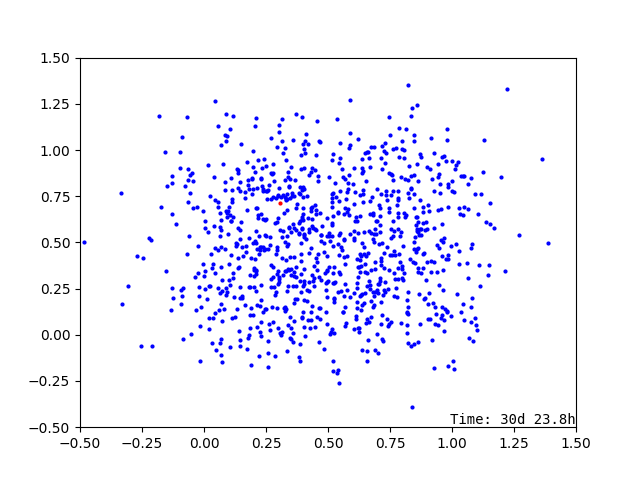

In [13]:
figure_animace, ln1, ln2, ln3, title = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), 
                    blit=True,interval=1,repeat=False)
plt.show()

Abychom mohli pokročit dál, budeme muset naprogramovat průběh nákazy. Jedním z důležitých faktorů je vzdálenost mezi nakaženým **I** a nakazitelným **S** jedincem.

Abychom so toto mohli lépe ozkoušet, nastavíme nákazu dalším 5 lidem a ukážeme si jak jednoduše z booleovsých polí **S,I,R** dostat pole indexů s hodnotou True.

In [14]:
I[7]=True; S[7]=False;
I[12]=True; S[12]=False;
I[15]=True; S[15]=False;
I[6]=True; S[6]=False;
I[3]=True; S[3]=False;
idx_I, = I.nonzero()
print(idx_I)

[ 0  3  6  7 12 15]


Je tam také index 0 protože jsme ho měli už v inicializaci.

Řekněme, že lidé se mohou nakazit, pokud jsou ve vzdálenosti menší než 0.02 od infikovaného.

In [15]:
vzdalenost_nakazy = 0.02
mohl_se_nakazit = np.full(pocet_lidi,False)

## Úkol 3: spočtěte vzdálenosti mezi nakaženými **I** a nakazitelnými **S**, pokud má nakazitelný **S** vzdálenost do některého nakaženého menší než **vzdalenost_nakazy** pak vepište do příslušné pozice v poli **mohl_se_nakazit** hodnotu True

In [16]:
idx_I, = I.nonzero()
idx_S, = S.nonzero()

def delka_vektoru(vec):
    return np.linalg.norm(vec)

for i in idx_I:
    for j in idx_S:
        distance = delka_vektoru(pozice[i,:]-pozice[j,:])
        if distance <= vzdalenost_nakazy:
            mohl_se_nakazit[j] = True

Pro kontrolu si vykresleme nakažené jedince a ty z **S** kteří se nakazit mohli:

<IPython.core.display.Javascript object>


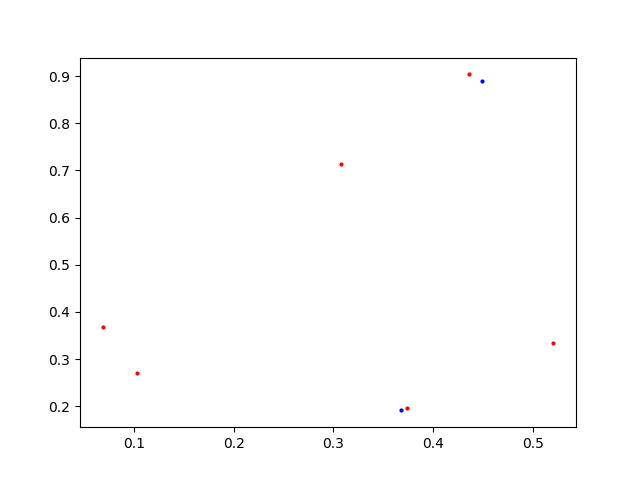

In [17]:
plt.figure()
plt.plot(pozice[S & mohl_se_nakazit,0],pozice[S & mohl_se_nakazit,1],"bo",markersize=2)
plt.plot(pozice[I,0],pozice[I,1],"ro",markersize=2)

Doufám, že se vše zdařilo, pokud ne, podívejte se do řešení, bez této části se totiž dále nedostaneme.

Jelikož né vždy, když se dostanete do blízkosti nakaženého se hned nakazíte, budeme chtít toto zanést i do našeho modelu. Jelikož budeme pracovat s 15 minutovými časovými kroky, můžeme pracovat s pravděpodobností nákazy 5 %. 

To znamená, že pokud se po dobu 15 minut (náš časový krok) pohybujete v blízkosti nakaženého, je 5 % šance, že se nakazíte. **5 % od každého nakaženého**, asi souhasite s tím, že při pohybu mezi 10 nakaženými je šance nákazy výrazně větší, než při pohybu v blízkost 1-ho nakaženého. (nikliv však 10x větší - můžete si rozmyslet) 

In [18]:
pravdepodobnost_nakazy = 0.05
np.random.rand() < pravdepodobnost_nakazy # takto vyrobíme náhodný pokus, kde s pravděpodobností 5 % výjde True

False

## Úkol 4: modifikujte výsledek minulého úkolu, tak ať pro každého ze skupiny **S** v kontaktu s každým nakaženým je aplikována šance na nákazu. Kód zabalte do funkce, jejíž výstupem bude pole nově nakažených

In [19]:
def nove_nakazeni():
    nakazili_se = np.full(pocet_lidi,False)
    idx_I, = I.nonzero()
    idx_S, = S.nonzero()
    for i in idx_I:
        for j in idx_S:
            distance = delka_vektoru(pozice[i,:]-pozice[j,:])
            if distance <= vzdalenost_nakazy:
                if np.random.rand() < pravdepodobnost_nakazy:
                    nakazili_se[j] = True
    return nakazili_se

Nyní můžeme upravit funkci **update** tak aby používala nově vyrobenou funkci:

In [20]:
def update(cas_simulace_minuty):
    pozice[:,:] += (np.random.rand(pocet_lidi,2)-0.5)/100 #totéž co v předchozí funkci
    
    nakazili_se = nove_nakazeni() # naše nový funkce
    
    I[nakazili_se] = True # změna stavu dle nových nákaz
    S[nakazili_se] = False
    
    vykresleni(cas_simulace_minuty) 
    return ln1,ln2,ln3,title 

A spustíme simulaci, ať vidíme co se nám povedlo:

<IPython.core.display.Javascript object>


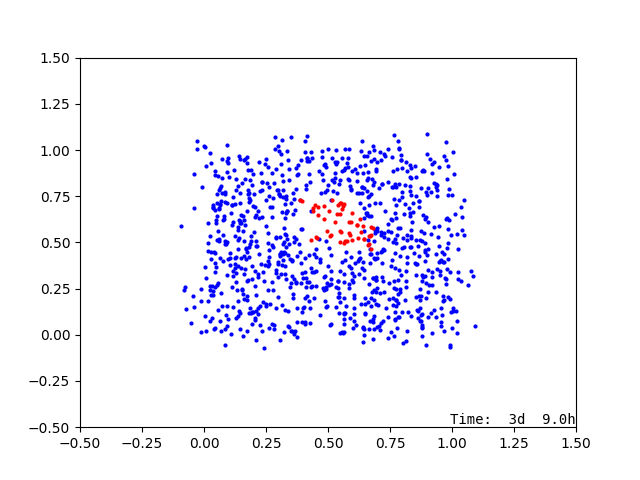

In [21]:
pozice, S, I, R = reset_simulace()
figure_animace, ln1, ln2, ln3, title = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), 
                    blit=True,interval=1,repeat=False)
plt.show()

Gratuluji, pokud vám to běží. Nicméně jste si pravděpodobně všimli, že je to nyní velice pomalé. Je to tím, že i takto jednoduchá simulace vyžaduje mnoho výpočtů, ktere navíc nyní děláme velice neefektivně.

Výpočty se dají dělat mnohem efektivněji, vyzkoušete simulaci s tímto kódem:

In [22]:
def nove_nakazeni():
    pI1 = pozice[I,0]; pI2 = pozice[I,1]; # vybereme si x a y pozice všech nakažených
    pS1 = pozice[S,0]; pS2 = pozice[S,1]; # vybereme si x a y pozice všech nakazitelných
    pS1 = pS1[None]; pS2 = pS2[None]; # původní pole pS1 a pS2 byly 1d a my budeme potřeboat jejich transpozici
    pS1 = pS1.T; pS2 = pS2.T; # zde je traspozice, nyní jsme ji mohli udělat (předchozí řádek jim přidal dimenzi)
    r1=pS1-pI1 #rozdíl v x souřadnicích (všiněme si, že je to sloupec - řádek, python je chytrý tak vyrobí matici)
    r2=pS2-pI2 #rozdíl v y souřadnicích -- takovéto práci s vektory se říká broadcasting 
    mohli_se_nakazit = (r1*r1+r2*r2) < vzdalenost_nakazy**2 #vyhneme se počítání odmocniny, tak že porovnáme s x^2
    mn = mohli_se_nakazit.shape #velikost výsledné matice
    nakazili_se_loc = np.random.rand(mn[0],mn[1]) < pravdepodobnost_nakazy #šance, že se nakazili, ale pro všechny
    nakazili_se_loc = nakazili_se_loc & mohli_se_nakazit #nakažení jsou ti kteří měli True na šanci a byli blízko
 
    nakazili_se = np.full(pocet_lidi,False) #alokace výsledného pole
    nakazili_se[S] = nakazili_se_loc.sum(1) #zapsání npočtených výsledků (suma přes všechny kontkakty s nemocnými)
    return nakazili_se

Nelam te si hlavu s tím co tento kód přesně dělá. Jeho podrobné pochopení je nad rámec tohoto kurzu.

Raději ho vyzkoušejte:

<IPython.core.display.Javascript object>


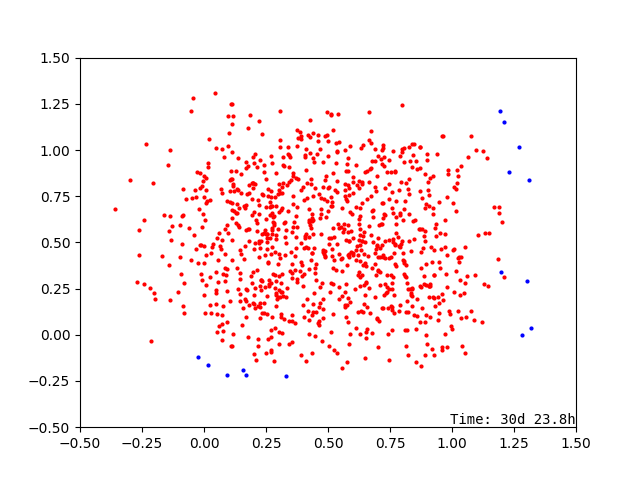

In [23]:
pozice, S, I, R = reset_simulace()
figure_animace, ln1, ln2, ln3, title = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), 
                    blit=True,interval=1,repeat=False)
plt.show()

Vidíme, že se naše nákaza velmi rychle šíří. Chybí nám však mechanizmus, který převede infekční jedince na jedince bez nákazy a zároveň jedince dále nenakazitelné.

To vyřešíme pomocí počítadla doby nákazy:

In [24]:
delka_nakazy = 7*24*15
doba_od_nakazeni = np.zeros((pocet_lidi))

## Úkol 4: přidejte do funkce update načítání času pro nakažené, dále v každém kroce kotrolujte, jestli čas nepřekročil délku nákazy, pokud ano přesuňte jedince z I do R


In [25]:
def update(cas_simulace_minuty):
    pozice[:,:] += (np.random.rand(pocet_lidi,2)-0.5)/100 #totéž co v předchozí funkci
    
    nakazili_se = nove_nakazeni() # naše nový funkce
    
    I[nakazili_se] = True # změna stavu dle nových nákaz
    S[nakazili_se] = False
    
    doba_od_nakazeni[I] +=15
    po_nemoci = doba_od_nakazeni >= delka_nakazy
    
    I[po_nemoci] = False
    R[po_nemoci] = True
     
    vykresleni(cas_simulace_minuty) 
    return ln1,ln2,ln3,title 

Vyzkoušíme nově vytvořenou funkci: (vyzkoušejte si o spustit více krát, vzhledem k náhodnému generování výsledků to bude mít pokaždé jiný průběh)

<IPython.core.display.Javascript object>


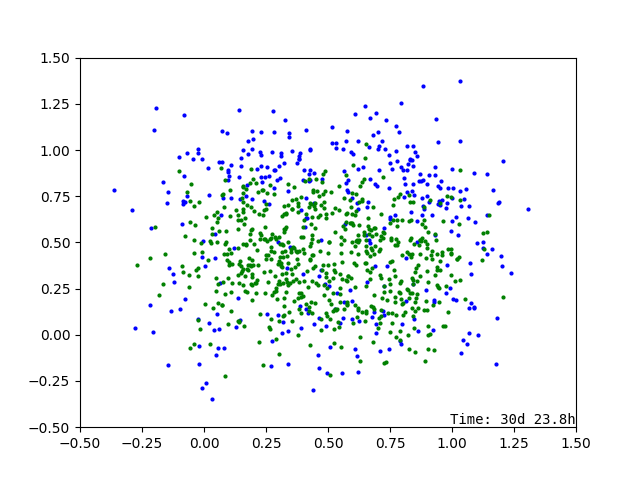

In [26]:
doba_od_nakazeni = np.zeros((pocet_lidi))
pozice, S, I, R = reset_simulace()
figure_animace, ln1, ln2, ln3, title = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), 
                    blit=True,interval=1,repeat=False)
plt.show()